In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [3]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [4]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [5]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [6]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# number of EOFs to retain for the LIM state vector
ntrunc = 30 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 1
ntraintimes = 1980
# nvalidtimes = 1872
nttrain_valid = 0
tscut_era = False    # time start cut 
tecut_era = False       # time end cut 

tscut_sat = False    # time start cut 
tecut_sat = 0       # time end cut 

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['tas','tos','psl','sic']
limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
#limvars = ['tas','tos','psl','sit','sic']
#limvars = ['tas','tos','sic']
#limvars_nosic = ['tas','tos']
limvars_nosic = []
nvars = len(limvars)

# specify the model source 
#train_dsource = 'ccsm4_hist_kb'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'cmip6_cesm2_ssp585'
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'mpi_lm_kb'
train_era = 'era5'
#train_dsource = 'era5'
#valid_dsource = 'mpi_lm_kb'
valid_sat = 'satellite'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False

In [ ]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_era = limkb.build_training_dic(train_era)
fdic_sat = limkb.build_training_dic(valid_sat)

full_names, areawt_name, month_names = limbuild.load_full_names()
areacell_era, areacell_dict_era = limbuild.load_areacell_dict(fdic_era, remove_climo=False, 
                                                              detrend=False, verbose=False )
areacell_sat, areacell_dict_sat = limbuild.load_areacell_dict(fdic_sat, remove_climo=False, 
                                                              detrend=False, verbose=False )

In [ ]:
tscut_era, tecut_era

In [ ]:
var_era = 'sic'
var_dict_era = {}

X_var_era, var_dict_era = limkb.load_data(var_era, var_dict_era, fdic_era, remove_climo=True, 
                                  detrend=True, verbose=True, cmip6=False, 
                                  tscut=tscut_era, tecut=tecut_era)
tsamp_era = X_var_era.shape[1]

if var_era is 'sic':
    if np.nanmax(X_var_era)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var_era = X_var_era/100

acell_era = areacell_era[areawt_name[var_era]]
units_era = areacell_dict_era[areawt_name[var_era]][areawt_name[var_era]]['units']

if 'km' in units_era:
    acell_era = acell_era
else: 
    print('changing cellarea units from '+
          str(units_era)+' to km^2')
    acell_era = acell_era/(1000*1000)
    units_era = 'km^2'

In [ ]:
var_sat = 'sic'
var_dict_sat = {}

X_var_sat, var_dict_sat = limkb.load_data(var_sat, var_dict_sat, fdic_sat, remove_climo=True, 
                                  detrend=True, verbose=True, cmip6=False, 
                                  tscut=tscut_era, tecut=tecut_era)
tsamp_sat = X_var_sat.shape[1]

if var_sat is 'sic':
    if np.nanmax(X_var_sat)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var_sat = X_var_sat/100

acell_sat = areacell_sat[areawt_name[var]]
units = areacell_dict_sat[areawt_name[var_sat]][areawt_name[var_sat]]['units']

if 'km' in units:
    acell_sat = acell_sat
else: 
    print('changing cellarea units from '+
          str(units)+' to km^2')
    acell_sat = acell_sat/(1000*1000)
    units_sat = 'km^2'

In [ ]:
var_era2 = 'sic'
var_dict_era2 = {}

X_var_era2, var_dict_era2 = limkb.load_data(var_era2, var_dict_era2, fdic_era, remove_climo=True, 
                                  detrend=True, verbose=True, cmip6=False, 
                                  tscut=26, tecut=False)
tsamp_era2 = X_var_era.shape[1]

if var_era2 is 'sic':
    if np.nanmax(X_var_era2)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var_era2 = X_var_era2/100

acell_era2 = areacell_era[areawt_name[var_era2]]
units_era2 = areacell_dict_era[areawt_name[var_era2]][areawt_name[var_era]]['units']

if 'km' in units_era2:
    acell_era2 = acell_era2
else: 
    print('changing cellarea units from '+
          str(units_era2)+' to km^2')
    acell_era2 = acell_era2/(1000*1000)
    units_era2 = 'km^2'

In [ ]:
if var == 'sic':
    tot_var_era5 = statskb.calc_tot_si(X_var_era,acell_era,units_era,var_dict_era[var_era]['lat'],lat_cutoff=0.0)
    tot_var_era5_2 = statskb.calc_tot_si(X_var_era2,acell_era2,units_era2,var_dict_era2[var_era2]['lat'],lat_cutoff=0.0)
    tot_var_sat = statskb.calc_tot_si(X_var_sat,acell_sat,units_sat,var_dict_sat[var_sat]['lat'],lat_cutoff=0.0)
else: 
    tot_var_era5 = statskb.global_mean(X_var_era,acell_era)
    tot_var_sat = statskb.global_mean(X_var_sat,acell_sat)

In [ ]:
from datetime import datetime, timedelta

sat_time = np.array([datetime(y,n,1) for y in range(1979, 2017) for n in range(1, 13)])
era_time = np.array([datetime(y,n,1) for y in range(1979, 2021) for n in range(1, 13)])

In [ ]:
fig = plt.figure(figsize=(8,4))

plt.plot(era_time,tot_var_era5, label='ERA5')

plt.ylabel('Total Arctic sea ice area \n(10$^6$ km$^2$)', fontsize=14)

plt.legend(fontsize=12, loc='lower right')
i = 312
plt.xlim(era_time[i],era_time[-1])
plt.ylim(-110,50)

In [ ]:
np.nanmean(tot_var_era5[26*12:])

In [ ]:
tot_var_era5_valid = tot_var_era5[26*12:] - np.nanmean(tot_var_era5[26*12:])

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.plot(era_time[26*12:],tot_var_era5_2, label='ERA5')

plt.ylabel('Total Arctic sea ice area \n(10$^6$ km$^2$)', fontsize=14)

plt.legend(fontsize=12, loc='lower right')
i = 312
plt.xlim(era_time[i],era_time[i+20])
plt.ylim(-110,50)

In [ ]:
tot_var_era5.mean()

In [ ]:
fig = plt.figure(figsize=(8,4))

#plt.plot(era_time, tot_var_era5, label='ERA5')
plt.plot(sat_time, tot_var_sat/1e6, label='Satellite')
plt.plot(era_time, tot_var_era5/40, label='ERA5')

plt.ylabel('Total Arctic sea ice area \n(10$^6$ km$^2$)', fontsize=14)

plt.legend(fontsize=12, loc='lower right')


In [ ]:
areacell_era[areawt_name[var_era]]

In [ ]:
acell_era*100, acell_sat

In [ ]:
X_var_sat.shape, X_var_era.shape

In [ ]:
X_var_era_3d = np.reshape(X_var_era,(181,720,504))
X_var_sat_3d = np.reshape(X_var_sat,(448,304,456))

In [ ]:

plt.pcolormesh(X_var_sat_3d[:,:,0])
plt.colorbar()

In [ ]:
plt.pcolormesh(X_var_era_3d[:,:,0])
plt.colorbar()

In [ ]:
iter_range = [4,5]
MCiters = range(iter_range[0],iter_range[1]+1)


In [ ]:
areacell_dict_era['areacello']['areacello']['lon'].shape

In [ ]:
np.where(areacell_dict_era['areacello']['areacello']['lat']>=31.1)

In [ ]:
lats = areacell_dict_era['areacello']['areacello']['lat'][np.where(areacell_dict_era['areacello']['areacello']['lat']>=31.1)]
lons = areacell_dict_era['areacello']['areacello']['lon']

In [ ]:
np.reshape(acell_era,(181,720))[:117,:].shape, lats.shape

In [ ]:
lats = areacell_dict_era['areacello']['areacello']['lat'][np.where(areacell_dict_era['areacello']['areacello']['lat']>=31.1)]
lons = areacell_dict_era['areacello']['areacello']['lon']

plt.pcolormesh(lons,lats,np.reshape(acell_era,(181,720))[:118,:])
plt.colorbar()

In [ ]:
lats_sat = areacell_dict_sat['areacello']['areacello']['lat']
lons_sat = areacell_dict_sat['areacello']['areacello']['lon']

In [ ]:
plt.pcolormesh(np.reshape(acell_sat,(448,304)))
plt.colorbar()

In [ ]:
plt.pcolormesh(lats_sat,lons_sat,np.reshape(acell_sat,(448,304)))
plt.colorbar()

In [ ]:
lats_sat.shape,lons_sat.shape,np.reshape(acell_sat,(448,304)).T.shape

In [ ]:
acell_sat.min(), acell_sat.max()

In [ ]:
plt.pcolormesh(np.reshape(acell_era,(181,720)))
plt.colorbar()

In [ ]:
acell_era.min(), acell_era.max()

# Estimate grid cell area: 

In [ ]:
r_earth = 6371.0 # km 
degrees = 0.5

rads = (np.pi/180)*degrees

In [ ]:
arc_length = r_earth*rads

acell_nowt = arc_length*arc_length*np.ones((181,720))

In [ ]:
lat_weights = np.cos(np.deg2rad(var_dict_era['sic']['lat']))

acell_wt = acell_nowt*lat_weights[:,np.newaxis]

In [ ]:
plt.pcolormesh(acell_wt)
plt.colorbar()

In [ ]:
plt.plot(lat_weights)

In [ ]:
arc_length*arc_length

# Test one month LIM: 

In [80]:
# number of EOFs to retain for the LIM state vector
ntrunc = 30 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

#mo='all'
mo=4

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 1
ntraintimes = 1980
# nvalidtimes = 1872
nttrain_valid = 0
tscut_era = False    # time start cut 
tecut_era = False       # time end cut 

tscut_sat = False    # time start cut 
tecut_sat = 0       # time end cut 

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['tas','tos','psl','sic']
limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
#limvars = ['tas','tos','psl','sit','sic']
#limvars = ['tas','tos','sic']
#limvars_nosic = ['tas','tos']
limvars_nosic = []
nvars = len(limvars)

# specify the model source 
#train_dsource = 'ccsm4_hist_kb'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'cmip6_cesm2_ssp585'
#train_dsource = 'cmip6_mpi_hist'
train_dsource = 'mpi_lm_kb'
#train_dsource = 'era5'
valid_dsource = 'era5'
#valid_dsource = 'mpi_lm_kb'
#valid_sat = 'satellite'
#valid_dsource = 'ccsm4_lm_kb'
#valid_dsource = 'cmip6_mpi_hist'

sic_separate = True
Insamp = False

In [81]:
# Start with truncated training data: 
#mod_folder = 'truncated_model_data/last_millennium/'
#mod_folder = 'truncated_model_data/'#+folder_add
mod_folder = ''#+folder_add
#mod_filename = '_ntrunc'+str(ntrunc)+'_month'+str(mo)+'_'+train_dsource+'_'+'ntrain_1850_2004_20210921.pkl'
mod_filename = '_ntrunc'+str(ntrunc)+'_month'+str(mo)+'_'+train_dsource+'_grid05_ntrain_1979_2004_20210914.pkl'

#mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_month'+str(mo)+'_'+train_dsource+'_ntrain_1850_2050_20210916.pkl'
mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_month'+str(mo)+'_'+train_dsource+'_grid05_ntrain_1979_2004_20210921.pkl'
#mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_month'+str(mo)+'_'+train_dsource+'_'+'ntrain_1850_2004_20210921.pkl'
mod_sic_filename = '_ntrunc50_month4_mpi_lm_kb_ntrain_850_1833_20210921.pkl'

In [92]:
exp_setup = {}
exp_setup['mo'] = mo
if 'all' in str(mo): 
    exp_setup['ind_month_trunc'] = False
else: 
    exp_setup['ind_month_trunc'] = True
exp_setup['tau'] = tau
exp_setup['ntrunc'] = ntrunc 
exp_setup['nmodes_sic'] = nmodes_sic
exp_setup['limvars'] = limvars
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 
exp_setup['sic_separate'] = sic_separate
exp_setup['Insamp'] = Insamp
exp_setup['mod_folder'] = mod_folder
exp_setup['mod_filename'] = mod_filename
exp_setup['mod_sic_filename'] = mod_sic_filename
exp_setup['Weight']=True
# era5 settings: 
# exp_setup['nyearsvalid'] = 16
# exp_setup['nyearstot'] = 42
# exp_setup['nyears_startvalid'] = 26*12

# Satellite settings: 
# exp_setup['nyearsvalid'] = 12
# exp_setup['nyearstot'] = 38
# exp_setup['nyears_startvalid'] = 26*12

# Historical settings: 
# exp_setup['nyearsvalid'] = 11
# exp_setup['nyearstot'] = 164
# exp_setup['nyears_startvalid'] = 154*12

# LM settings
exp_setup['nyearsvalid'] = 16
exp_setup['nyearstot'] = 1000
exp_setup['nyears_startvalid'] = (1000-16)*12

exp_setup['ntrain']=((exp_setup['nyearstot']*12)-(exp_setup['nyearsvalid'] *12))/(exp_setup['nyearstot']*12)

In [93]:
import run_forecast_model_data as rf

In [94]:
importlib.reload(rf)
importlib.reload(limbuild)
importlib.reload(limkb)
importlib.reload(statskb)

<module 'LIM_stats_kb' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_stats_kb.py'>

In [95]:
def load_training_data_truncated(limvars, mod_folder, mod_sic_filename, mod_filename,
                                 mo, nyearstot, nyearsvalid, ind_month_trunc = False): 

    var_dict = {}
    v = {}
    tot_var = {}
    tot_var_eig = {}
    W_all = {}
    E3 = {}
    Ptrunc = {}
    Ptrunc_valid = {}
    standard_factor = {}
    
    for k, var in enumerate(limvars): 
        if var == 'sic': 
            mod_fname = mod_sic_filename
        else: 
            mod_fname = mod_filename
    
        [X_var, v, E3[var], standard_factor[var], 
         W_all[var]] = limkb.load_truncated_data(var, mod_folder, mod_fname)
        
        var_dict[var] = v[var]
    
        if mo is 'all':
            X_t = X_var
            ntime = X_t.shape[1]
            nyears_train = int(ntrain*ntime)
            nyears_valid = ntime - nyears_train

            X_train = X_t[:,0:nyears_train]
            X_train_2d = X_train
            X_valid = X_t[:,nyears_train:]
        elif ind_month_trunc is True: 
            ntime = X_var.shape[1]
            nyears_train = nyearstot - nyearsvalid
            nyears_valid = nyearsvalid
            
            X_t = np.reshape(X_var,(X_var.shape[0],int(ntime/2),2))

            X_train = X_t
            X_train_2d = np.reshape(X_train,(X_train.shape[0],nyears_train*2))
            X_valid = X_t[:,:,1]
        else: 
            ntime = X_var.shape[1]
            nyears_train = int((ntime*ntrain)/12)
            nyears_valid = int((ntime*(1-ntrain))/12)

            X_t = np.reshape(X_var,(X_var.shape[0],int(ntime/12),12))

            X_train = X_t[:,0:nyears_train,mo:mo+2]
            X_train_2d = np.reshape(X_train,(X_train.shape[0],nyears_train*2))
            X_valid = X_t[:,nyears_train:,mo]

        Ptrunc[var] = X_train_2d 
        Ptrunc_valid[var] = X_valid
#         Ptrunc_valid[var] = limkb.step1_projection_validation_var(X_valid, E3[var], standard_factor[var], 
#                                                                   W_all[var])

        del X_var
    
    return Ptrunc, Ptrunc_valid, E3, tot_var, tot_var_eig, W_all, standard_factor, nyears_train, var_dict

In [96]:
[Ptrunc, _, E3, tot_var, 
 tot_var_eig, W_all, 
 standard_factor, 
 nyears_train, var_dict] = load_training_data_truncated(exp_setup['limvars'], exp_setup['mod_folder'], 
                                                        exp_setup['mod_sic_filename'], 
                                                        exp_setup['mod_filename'], 
                                                        exp_setup['mo'],exp_setup['nyearstot'],
                                                        exp_setup['nyearsvalid'],
                                                        ind_month_trunc=exp_setup['ind_month_trunc'])

Loading truncated sic from: sic_ntrunc50_month4_mpi_lm_kb_ntrain_850_1833_20210921.pkl


In [97]:
var_dict = limbuild.get_var_indices(exp_setup['limvars'], var_dict)

ndof_all = limkb.count_ndof_all(exp_setup['limvars'], E3, sic_separate=exp_setup['sic_separate'])


if len(exp_setup['limvars'])<=1:
    print('Only one variable detected...')
    Ptrunc_all = []
    E3_all = []
    Ptrunc_sic = Ptrunc['sic']
    E_sic = E3['sic']

    P_train = Ptrunc_sic
else: 
    print('Multiple variables detected...')
    [Ptrunc_all, E3_all, 
    Ptrunc_sic,E_sic] = limkb.stack_variable_eofs(exp_setup['limvars'], ndof_all, 
                                                  exp_setup['ntrunc'], Ptrunc, E3,var_dict,
                                                  sic_separate=exp_setup['sic_separate'])

    P_train = np.concatenate((Ptrunc_all, Ptrunc_sic),axis=0)

working on sic
Only one variable detected...


In [98]:
# TRAIN LIM: 
    #--------------------------------------------------

nmo = int(P_train.shape[1]/nyears_train)
# nmo = 2
P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

if exp_setup['mo'] is 'all':
    LIMd2, G2 = lim.LIM_train(exp_setup['tau'],P_train)
    print('Training LIM with tau = '+str(exp_setup['tau']))
else: 
    LIMd2, G2 = lim.LIM_train_flex(exp_setup['tau'],P_train_3d[:,:,0], P_train_3d[:,:,1])
    print('Training LIM with tau = '+str(exp_setup['tau']))

Training LIM with tau = 1


(0, 100)

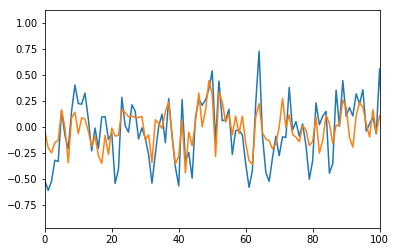

In [103]:
plt.plot(P_train_3d[3,:,0])
plt.plot(P_train_3d[3,:,1])
plt.xlim(0,100)

In [104]:
P_train_3d.shape

(50, 984, 2)

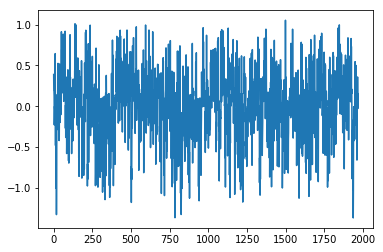

In [100]:
plt.plot(P_train[0,:])

In [101]:
#--------------------------------------------------

max_eigenval = np.real(LIMd2['lam_L']).max()

if max_eigenval >0: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L'] - (max_eigenval+0.01)
else: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L']

LIMd2['npos_eigenvalues'] = (LIMd2['lam_L']>0).sum()/(LIMd2['lam_L'].shape[0])
print('Number of positive eigenvalues = '+ str((LIMd2['lam_L']>0).sum()/(LIMd2['lam_L'].shape[0])))

Number of positive eigenvalues = 0.3


In [102]:
LIMd2['lam_L']

array([ 0.79059657+0.j        ,  0.03745065+1.16497518j,
        0.03745065-1.16497518j, -0.00642996+0.98962328j,
       -0.00642996-0.98962328j,  0.4135341 +0.j        ,
        0.35939045+0.2086828j ,  0.35939045-0.2086828j ,
        0.10349911+0.51134626j,  0.10349911-0.51134626j,
        0.30045094+0.j        ,  0.26339739+0.15950429j,
        0.26339739-0.15950429j, -1.51328073+1.26342935j,
       -1.51328073-1.26342935j, -0.17404285+0.64079333j,
       -0.17404285-0.64079333j, -1.74358904+1.06966527j,
       -1.74358904-1.06966527j, -3.3113672 +0.j        ,
       -2.31148708+0.40921287j, -2.31148708-0.40921287j,
       -2.48072065+0.j        , -2.30563025+0.j        ,
       -1.87345146+0.3465824j , -1.87345146-0.3465824j ,
       -1.38669109+0.28894138j, -1.38669109-0.28894138j,
        0.22167739+0.j        , -0.59472109+0.49781363j,
       -0.59472109-0.49781363j, -0.41562146+0.49563609j,
       -0.41562146-0.49563609j, -0.25674142+0.49018561j,
       -0.25674142-0.49018561j,